# Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Load Data

In [2]:
for dirname, _, filenames in os.walk("//Users/cemozb/Desktop/portfolio/FIFA - World Cup Data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
wc_1930 = pd.read_csv("/Users/cemozb/Desktop//FIFA_WC_Data_Analysis/FIFA - World Cup Data/FIFA - 1930.csv")
wc_1930.head()

,Position,Team,Games Played,Win,Draw,Loss,Goals For,Goals Against,Goal Difference,Points
0,1,Uruguay,4,4,0,0,15,3,12,8
1,2,Argentina,5,4,0,1,18,9,9,8
2,3,United States,3,2,0,1,7,6,1,4
3,4,Yugoslavia,3,2,0,1,7,7,0,4
4,5,Chile,3,2,0,1,5,3,2,4


In [4]:
wc_summary = pd.read_csv("/Users/cemozb/Desktop/FIFA_WC_Data_Analysis//FIFA - World Cup Summary.csv")
wc_summary.head()

,YEAR,HOST,CHAMPION,RUNNER UP,THIRD PLACE,TEAMS,MATCHES PLAYED,GOALS SCORED,AVG GOALS PER GAME
0,1930,Uruguay,Uruguay,Argentina,United States,13,16,70,3.6
1,1934,Italy,Italy,Czechoslovakia,Germany,16,17,70,4.1
2,1938,France,Italy,Hungary,Brazil,15,18,84,4.7
3,1950,Brazil,Uruguay,Brazil,Sweden,13,22,88,4.0
4,1954,Switzerland,West Germany,Hungary,Austria,16,26,140,5.4


In [5]:
DATASET_PATH ="/Users/cemozb/Desktop/FIFA_WC_Data_Analysis/FIFA - World Cup Data"

# List all CSV files
file_names = [f for f in os.listdir(DATASET_PATH) if f.endswith(".csv")]

# Load and combine all CSV files
df_list = [pd.read_csv(os.path.join(DATASET_PATH, file)) for file in file_names]
df = pd.concat(df_list, ignore_index=True)  # Merge all DataFrames

In [6]:
df.head()

,Position,Team,Games Played,Win,Draw,Loss,Goals For,Goals Against,Goal Difference,Points
0,1,Uruguay,4,3,1,0,15,5,10,7
1,2,Brazil,6,4,1,1,22,6,16,9
2,3,Sweden,5,2,1,2,11,15,−4,5
3,4,Spain,6,3,1,2,10,12,−2,7
4,5,Yugoslavia,3,2,0,1,7,3,4,4


# Data Exploration

In [7]:
print(df.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Position         489 non-null    int64 
 1   Team             489 non-null    object
 2   Games Played     489 non-null    int64 
 3   Win              489 non-null    int64 
 4   Draw             489 non-null    int64 
 5   Loss             489 non-null    int64 
 6   Goals For        489 non-null    int64 
 7   Goals Against    489 non-null    int64 
 8   Goal Difference  489 non-null    object
 9   Points           489 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 38.3+ KB
None


In [8]:
df.isnull().sum()

Position           0
Team               0
Games Played       0
Win                0
Draw               0
Loss               0
Goals For          0
Goals Against      0
Goal Difference    0
Points             0
dtype: int64

# Data Analysis

In [9]:
# Normalize values and return a list of RGBA colors using the given colormap.
def map_colors(values, cmap_name="Blues"):

    norm = Normalize(vmin=min(values), vmax=max(values))
    cmap = get_cmap(cmap_name)
    return [cmap(norm(val)) for val in values], cmap, norm

### Which team has the most World Cup appearances?

In [10]:
# Combine all teams from all DataFrames
all_teams = pd.concat(df_list)["Team"]

# Get unique teams
unique_teams = all_teams.unique()

print(f"There are {len(unique_teams)} unique teams out of the {len(all_teams)} total appearances in World Cup history.")

# Count appearances
team_apps_data = all_teams.value_counts().reset_index().rename(columns={"index": "Team", "Team": "Appearances"})

There are 88 unique teams out of the 489 total appearances in World Cup history.


/var/folders/7k/v7p94gsd69j49_qpn3c1vz080000gn/T/ipykernel_19676/1679980178.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap_name)


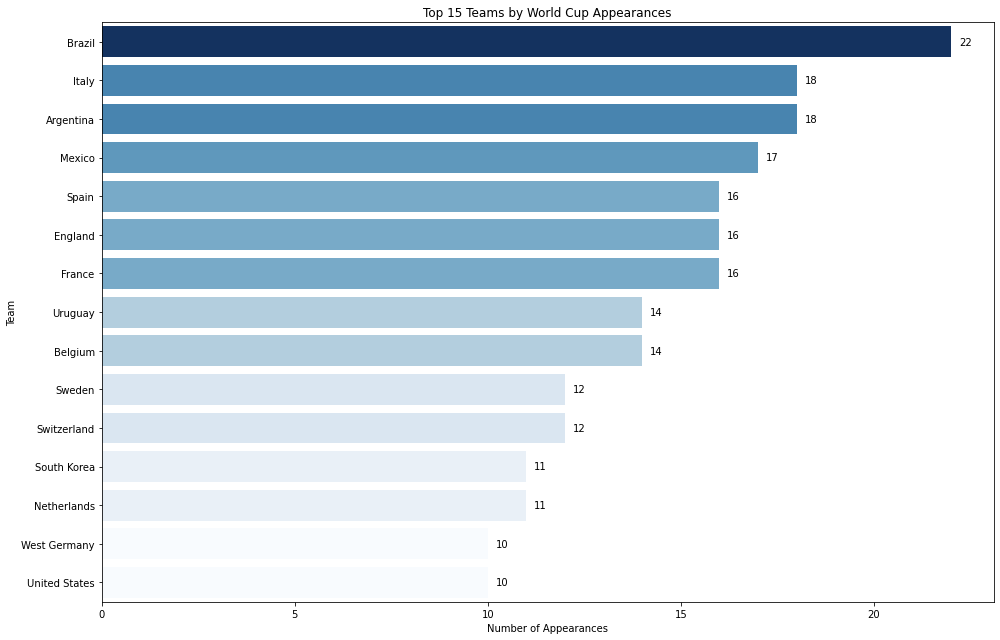

In [11]:
top_n = 15
plot_data = team_apps_data.head(top_n)

# Color mapping: darker = more appearances
colors, cmap, norm = map_colors(plot_data["Appearances"], cmap_name="Blues")

# Plot
plt.figure(figsize=(14, 9))
ax = sns.barplot(
    data=plot_data,
    y="Team",
    x="Appearances",
    palette=colors
)

plt.title(f"Top {top_n} Teams by World Cup Appearances")
plt.xlabel("Number of Appearances")
plt.ylabel("Team")

# Add labels
for i, row in plot_data.iterrows():
    ax.text(row["Appearances"] + 0.2, i, row["Appearances"], va="center")

plt.tight_layout()
plt.show()

### Appearances & Win Ratio

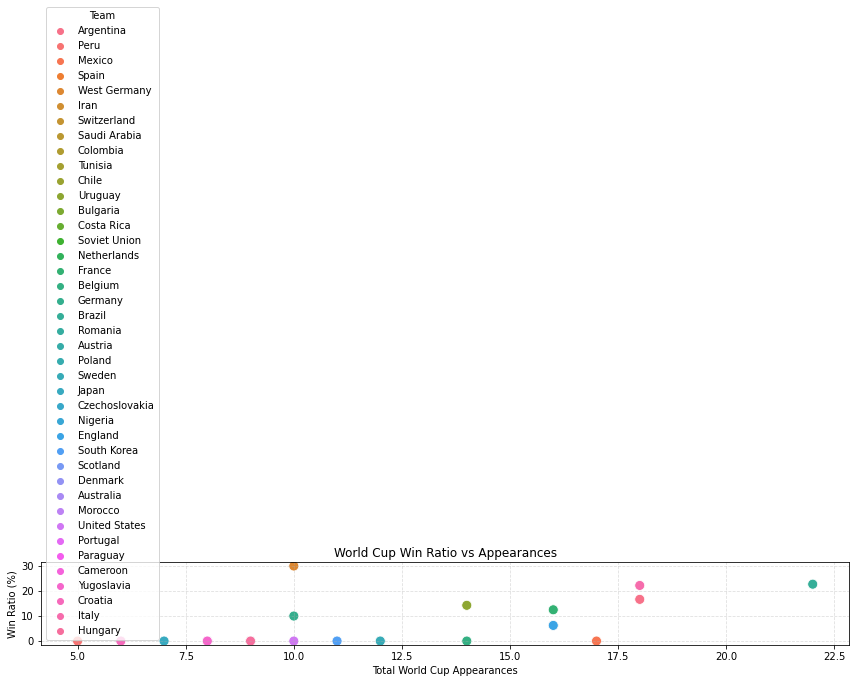

In [19]:
# 1. Count total appearances
list_of_teams = [team for df in df_list for team in df["Team"]]
unique_teams = list(set(list_of_teams))

team_apps = {
    "Team": [],
    "Appearances": []
}
for team in unique_teams:
    team_apps["Team"].append(team)
    team_apps["Appearances"].append(list_of_teams.count(team))

team_apps_data = pd.DataFrame(team_apps)

# 2. Count World Cup wins
win_counts = wc_summary["CHAMPION"].value_counts().reset_index()
win_counts.columns = ["Team", "Wins"]

# 3. Merge and compute win ratio
team_stats = pd.merge(team_apps_data, win_counts, on="Team", how="left")
team_stats = team_stats[team_stats["Appearances"] >= 5]

team_stats["Wins"] = team_stats["Wins"].fillna(0).astype(int)
team_stats["Win Ratio (%)"] = (team_stats["Wins"] / team_stats["Appearances"]) * 100

# 4. Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=team_stats, x="Appearances", y="Win Ratio (%)", hue="Team", s=100)

plt.title("World Cup Win Ratio vs Appearances")
plt.xlabel("Total World Cup Appearances")
plt.ylabel("Win Ratio (%)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### Which team has won the most World Cups

/var/folders/7k/v7p94gsd69j49_qpn3c1vz080000gn/T/ipykernel_19676/1679980178.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap_name)


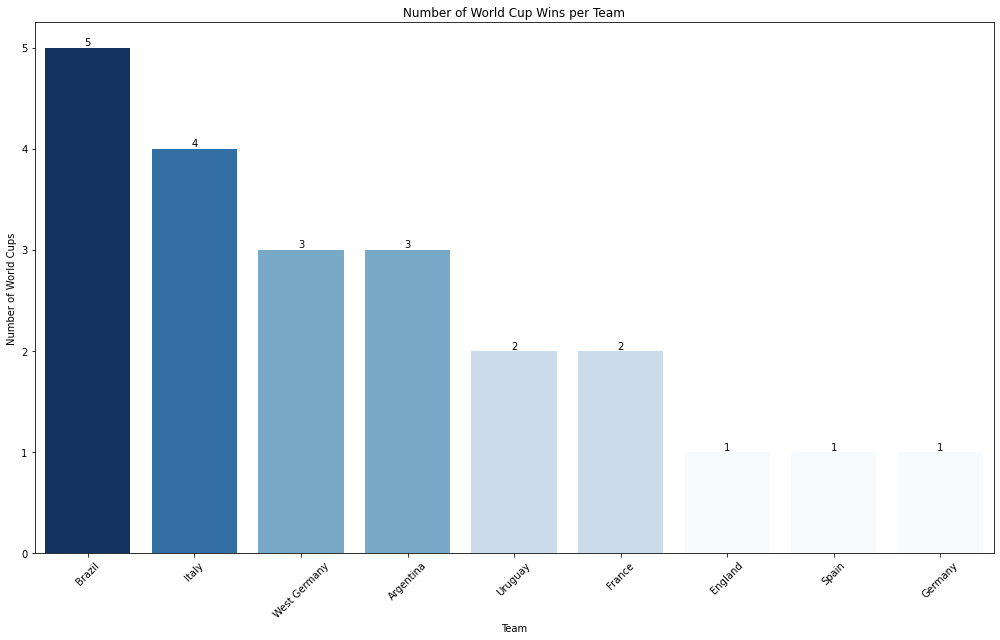

In [20]:
# Count World Cup wins
winner_counts = wc_summary["CHAMPION"].value_counts()
teams = winner_counts.index
counts = winner_counts.values

# Color mapping: darker = more wins
colors, cmap, norm = map_colors(counts, cmap_name="Blues")

# Plot
plt.figure(figsize=(14, 9))
ax = sns.barplot(x=teams, y=counts, palette=colors)

plt.title("Number of World Cup Wins per Team")
plt.xlabel("Team")
plt.ylabel("Number of World Cups")
plt.xticks(rotation=45)

# Add labels
for bar, count in zip(ax.patches, counts):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{int(count)}",
        ha="center", va="bottom"
    )

plt.tight_layout()
plt.show()

/var/folders/7k/v7p94gsd69j49_qpn3c1vz080000gn/T/ipykernel_19676/1679980178.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap_name)
/var/folders/7k/v7p94gsd69j49_qpn3c1vz080000gn/T/ipykernel_19676/881732177.py:26: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
/Users/cemozb/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


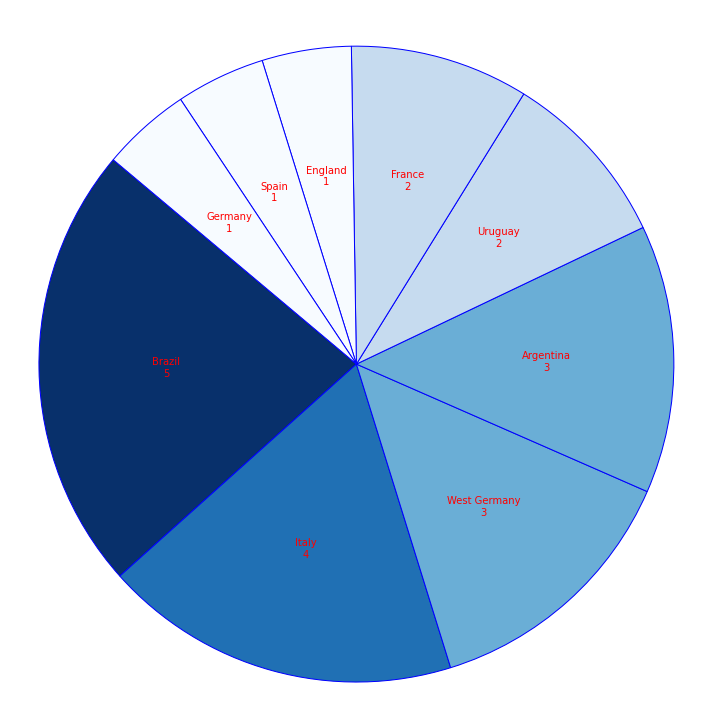

In [27]:
# Count World Cup wins
winner_counts = wc_summary["CHAMPION"].value_counts()
teams = winner_counts.index
counts = winner_counts.values

# Get colors based on win count
colors, _, _ = map_colors(counts, cmap_name="Blues")

# Create labels: "Team\nWins"
autopct_labels = [f"{team}\n{count}" for team, count in zip(teams, counts)]

# Plot pie with custom colors and internal labels
plt.figure(figsize=(10, 10))
wedges, texts, autotexts = plt.pie(
    counts,
    labels=None,
    colors=colors,
    autopct=lambda pct: autopct_labels.pop(0),
    startangle=140,
    textprops={"fontsize": 10, "color": "red"},
    wedgeprops={"edgecolor": "blue"}
)

plt.title("🏆 FIFA World Cup Wins by Country", fontsize=14, weight="bold", color="white")
plt.axis("equal")
plt.tight_layout()
plt.show()


### How has goalscoring improved throughout the years?

/var/folders/7k/v7p94gsd69j49_qpn3c1vz080000gn/T/ipykernel_19676/1679980178.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap_name)
/var/folders/7k/v7p94gsd69j49_qpn3c1vz080000gn/T/ipykernel_19676/2186311270.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Total Goals (Color Scale)")


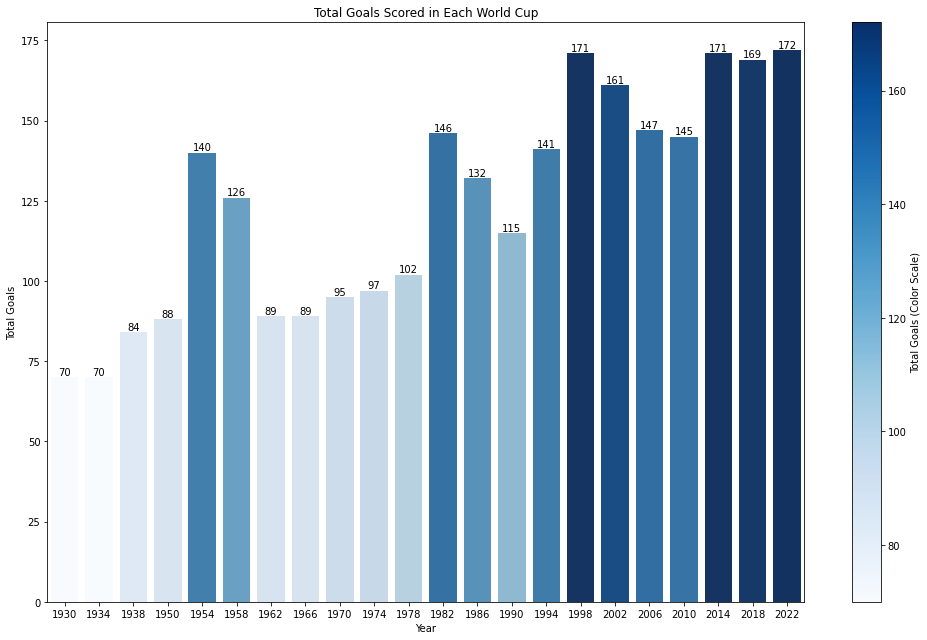

In [13]:
# Grouped data
goals_per_wc = wc_summary.groupby("YEAR")["GOALS SCORED"].sum()

# Get color mapping
colors, cmap, norm = map_colors(goals_per_wc.values, cmap_name="Blues")

# Plot
plt.figure(figsize=(14, 9))
bars = sns.barplot(x=goals_per_wc.index, y=goals_per_wc.values, palette=colors)

# Add colorbar legend
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="Total Goals (Color Scale)")

# Titles and labels
plt.title("Total Goals Scored in Each World Cup")
plt.xlabel("Year")
plt.ylabel("Total Goals")

# Add value labels on bars
for bar, value in zip(bars.patches, goals_per_wc.values):
    bars.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{int(value)}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

### Average Goals per Game by World Cup 

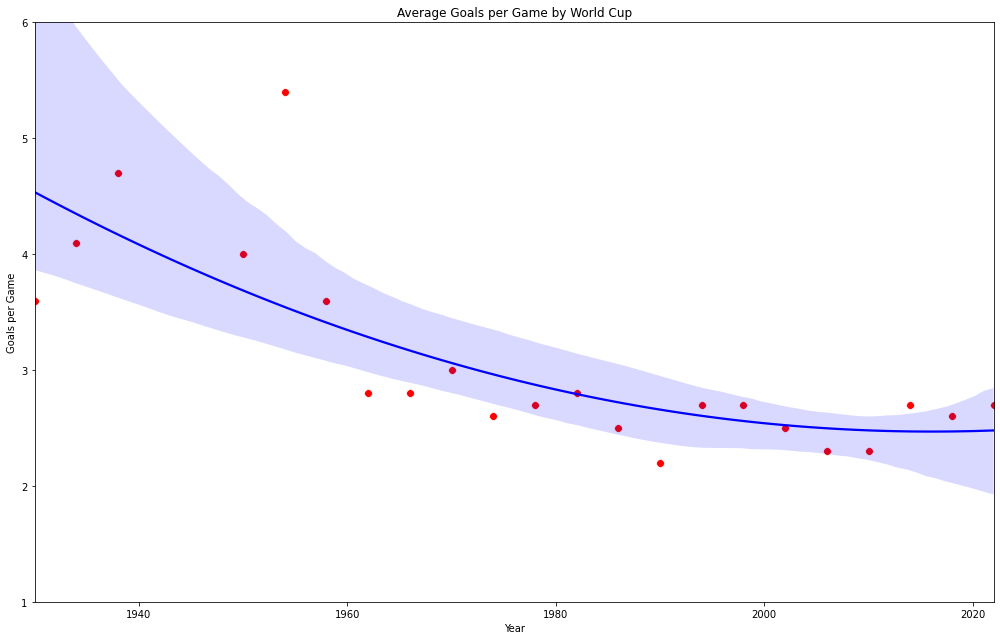

In [14]:
plt.figure(figsize=(14, 9))
sns.scatterplot(x="YEAR", y="AVG GOALS PER GAME", data=wc_summary, color="red", s=60)
sns.regplot(x="YEAR", y="AVG GOALS PER GAME", data=wc_summary, order=2, scatter=False, color="blue")

plt.title("Average Goals per Game by World Cup")
plt.xlabel("Year")
plt.ylabel("Goals per Game")
plt.ylim(1, 6)  # Set y-axis range
plt.tight_layout()
plt.show()

In [15]:
winner_stats = []

for df, year in zip(df_list, wc_summary["YEAR"]):
    winner_row = df[df["Position"] == 1].iloc[0]
    winner_stats.append({
        "YEAR": year,
        "Team": winner_row["Team"],
        "Goals For": winner_row["Goals For"],
        "Goals Against": winner_row["Goals Against"]
    })

winners_df = pd.DataFrame(winner_stats)

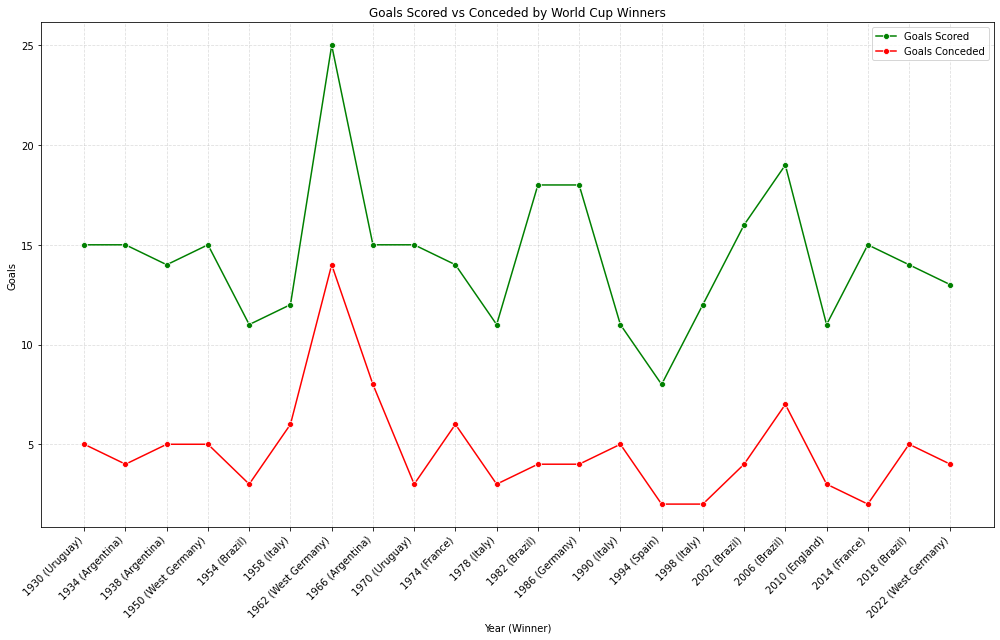

In [16]:
# Create custom x-axis labels: e.g., "1930 (Uruguay)"
winners_df["Year Label"] = winners_df["YEAR"].astype(str) + " (" + winners_df["Team"] + ")"

plt.figure(figsize=(14, 9))

# Plot goals scored and conceded
sns.lineplot(data=winners_df, x="Year Label", y="Goals For", label="Goals Scored", marker="o", color="green")
sns.lineplot(data=winners_df, x="Year Label", y="Goals Against", label="Goals Conceded", marker="o", color="red")

# Formatting
plt.title("Goals Scored vs Conceded by World Cup Winners")
plt.xlabel("Year (Winner)")
plt.ylabel("Goals")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
avg_goals_scored = winners_df["Goals For"].mean()
avg_goals_conceded = winners_df["Goals Against"].mean()

print(f"🔢 Average goals scored by winners: {avg_goals_scored:.2f}")
print(f"🔐 Average goals conceded by winners: {avg_goals_conceded:.2f}")

🔢 Average goals scored by winners: 14.41
🔐 Average goals conceded by winners: 4.73


### Insights:

Champions typically score around 14.41 goals, with standout attacks like Brazil in 1958 (25)

They usually concede only 4.73 goals, though exceptions exist, e.g. West Germany (1954) and France (2018)

Defensive stability is more consistent across winners than offensive power, low goals conceded is a common trait

No team has won with both weak attack and defense even defensively solid champions like Italy (2006) managed to score enough

### Conclusion:

Winning teams are more often defined by solid defense than high scoring

Defense wins championships but attack sometimes steals the show